# <span style="color:purple">Week 4 - Word Embeddings
### <span style="color:purple">World of Cooking</span>  
<span style="color:purple">-- File: Jingying (Jane) Bi Homework 4 <br>
-- Name: Jingying Bi <br>
-- UCID: 12174556 <br>
<br>
    
<span style="color:purple">**Research Problem:** <br>
How do cooking books reflect the culture behind it? <br>

<span style="color:purple">**Descriptions:** <br>
<span style="color:purple">I have collected different cook books about different countries' dishes, such as American, Swedish, Italian, Juish, and Western; also different cook books for different situations, such as for domestic cooking, hotel custoomers, farm cooking, neighborhood cooking, army cooking; also different cook books for breakfast, luch, tea time, for dishes & beverages, for fish cooking, for sick and convalescent. These are so interesting and I hope to study how different they are from each other. The differences are determined by the underlying cultures and also reflect the cultures in return. 

<span style="color:purple">**Main Findings:** <br>
(1) List the words having large cosine similarities with a certain word. This will reveal more information about that word. See the discussion in **Exercise 1.1**<br>
(2) Words with similar properties or discribing similar things cluster together in the plot. See the discussion in **Exercise 1.3**<br>
(3) Cook books from different cultures differ from each other within the space. See the discussion in **Exercise 2.1**<br>
(4) Cook books show similarities/ dissimilarities based on their culture background. See the discussion in **Exercise 2.2**<br>
    
<span style="color:purple">**Future Research:** <br>    
A potential interesting question is how the culture affects the cookings, and how the dissimilarities of cookings across different cultures evolve (more diverge or more similar) over time. To do so, I need to collect cook books from different cultures over time.<br>     
    
<span style="color:purple">**Dataset:** <br>
<span style="color:purple">The Feeding America: The Historic American Cookbook dataset contains transcribed and encoded text from 76 influential American cookbooks. Features encoded within the text include but are not limited to recipes, types of recipes, cooking implements, and ingredients. The texts were chosen among more than 7000 cookbooks as representative of periods and themes in American cookbook history spanning the late 18th to early 20th century. <br>

<span style="color:purple">**Citation:** <br>
<span style="color:purple">Feeding America: The Historic American Cookbook Dataset. East Lansing: Michigan State University Libraries Special Collections. https://www.lib.msu.edu/feedingamericadata/
    
![title](CookBook.jpg)

<span style="color:purple"> **Load the packages**

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
from nltk.corpus import stopwords
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

<span style="color:purple"> **Load, tokenize and normalize the copura**

In [2]:
# Load corpora 
CookBookDF = lucem_illud.loadTextDirectory('../4-Word-Embedding/CookBooks')
CookBookDF[:5]

,text
The Neighborhood Cook Book.txt,\n \n \n \n The Neighborhood Cook Book \n Cou...
Miss Corson's Practical American Cookery.txt,\n \n \n \n Miss Corson's Practical American ...
Svensk-Amerikansk Kokbok.txt,\n \n \n Svensk-Amerikansk Kokbok. Swedish-E...
Food and Cookery for the Sick and Convalescent.txt,\n \n \n \n Food and cookery for the sick and...
Jennie June's American Cookery Book.txt,\n \n \n \n The House Servant's Directory... ...


In [3]:
# Tokenize and normalize the texts
CookBookDF['tokenized_sents'] = CookBookDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
CookBookDF['normalized_sents'] = CookBookDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

CookBookDF[:5]

,text,tokenized_sents,normalized_sents
The Neighborhood Cook Book.txt,\n \n \n \n The Neighborhood Cook Book \n Cou...,"[[The, Neighborhood, Cook, Book, Council, of, ...","[[neighborhood, cook, book, council, jewish, w..."
Miss Corson's Practical American Cookery.txt,\n \n \n \n Miss Corson's Practical American ...,"[[Miss, Corson, 's, Practical, American, Cooke...","[[miss, corson, practical, american, cookery, ..."
Svensk-Amerikansk Kokbok.txt,\n \n \n Svensk-Amerikansk Kokbok. Swedish-E...,"[[Svensk-Amerikansk, Kokbok, .], [Swedish-Engl...","[[kokbok], [cookbook], [author, unknown, cooke..."
Food and Cookery for the Sick and Convalescent.txt,\n \n \n \n Food and cookery for the sick and...,"[[Food, and, cookery, for, the, sick, and, con...","[[food, cookery, sick, convalescent], [farmer,..."
Jennie June's American Cookery Book.txt,\n \n \n \n The House Servant's Directory... ...,"[[The, House, Servant, 's, Directory, ..., Rob...","[[house, servant, directory, roberts, robert],..."


In [4]:
# word to vector
CookBookW2V = gensim.models.word2vec.Word2Vec(CookBookDF['normalized_sents'].sum())
# see the vector of word "fish"
# CookBookW2V['fish']

## <span style="color:purple">1.1 Word2Vec and Word relationships in the Resulting Space

<span style="color:purple">**Interesting Question:**<br>
<span style="color:purple">What are the most representative words in these cook books?<br>

<span style="color:purple">**Method:**<br>
<span style="color:purple">(1) I search the words with high frequencies. They are the most representative words among all the cook books. <br>
<span style="color:purple">(2) Then I will find the words similar to these representative words, together with the cosine similarity between the two words.

<span style="color:purple">**Findings:**<br>
<span style="color:purple">(1)The representative words and their frequencies are: <br>
('one', 11125)('water', 9576)('160', 9188)('salt', 7041)('add', 6890)('two', 6575)('butter', 6573)('sugar', 6570)('then', 5911)('put', 5848)('cup', 5542)('flour', 5023)('eggs', 4762)('hot', 4534)('cold', 4036)('little', 3880)('cream', 3872)('half', 3859)('milk', 3842)('pepper', 3751)('small', 3690)('cut', 3674)('boil', 3433)('sauce', 3365)('three', 3110)('boiling', 3026)('one-half', 2699)('233', 2662),('oven', 2643),('meat', 2603)('egg', 2490)
<br>
I include these words into ***The List of Representative Words***<br>
    
<span style="color:purple">(2) By looking for the similar words based on cosine similarities, I obtain more information about the representative word.<br>
<span style="color:purple">For instance, the words similar to "water" are "liquid", "disolved", "liquor", "vinegar", "gelatine". In the context of cookings, "liquid" tells the status of "water". "disolved" tells the function of "water". "liquor", "vinegar", "gelatine" are fairly common objects relevant to "water" for cooking. <br>
<span style="color:purple">The words similar to "cold" are "boiling", "boils", "hot", "warm", "lukewarm". All of them are used to describe the temperature. The words similar to "cup" are "tablespoon", "teaspoon", "cups" "tablespponful", "pint", "quart", "spoonfull", "teaspoonfull". The first three words are the names of tableware, while the rest of them are the units or the ways to describe "how much" to use/ add, etc. <br>


In [5]:
# words and their frequencies -- generate the list of representative words
CookBookDF['tokenized_text'] = CookBookDF['text'].apply(lambda x: nltk.word_tokenize(x))
countsDict = {}
for word in CookBookDF['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [6]:
CookBookW2V.most_similar('water')

[('gelatine', 0.6732891798019409),
 ('dissolved', 0.6485925316810608),
 ('vinegar', 0.6478315591812134),
 ('liquid', 0.6466262340545654),
 ('nearly', 0.6309497356414795),
 ('bring', 0.6197890043258667),
 ('scald', 0.6195112466812134),
 ('kettle', 0.6158090233802795),
 ('throw', 0.6111495494842529),
 ('liquor', 0.6090911626815796)]

In [7]:
CookBookW2V.most_similar('cold')


[('warm', 0.7650133371353149),
 ('boiling', 0.7542831897735596),
 ('drained', 0.6641824245452881),
 ('previously', 0.6616337299346924),
 ('scalded', 0.6586393117904663),
 ('soaked', 0.6567875146865845),
 ('boiled', 0.6358659267425537),
 ('drain', 0.6301573514938354),
 ('hot', 0.6294578313827515),
 ('lukewarm', 0.6288045644760132)]

In [8]:
CookBookW2V.most_similar('cup')


[('cupful', 0.8992138504981995),
 ('tablespoon', 0.8906320333480835),
 ('pint', 0.8804406523704529),
 ('tablespoonful', 0.8569642901420593),
 ('cups', 0.841123104095459),
 ('quart', 0.834312915802002),
 ('gill', 0.8285434246063232),
 ('teaspoon', 0.7831034064292908),
 ('spoonful', 0.7800700664520264),
 ('teaspoonful', 0.776697039604187)]

In [9]:
CookBookW2V.doesnt_match(['water', 'sugar', 'butter', 'flour', 'eggs','cold','milk','cup','hot'])

'eggs'

In [10]:
CookBookW2V.most_similar(positive=['boiling', 'water'], negative = ['hot'])

[('gelatine', 0.6278140544891357),
 ('scald', 0.6240823268890381),
 ('brine', 0.6140077710151672),
 ('allowing', 0.6127336025238037),
 ('gallon', 0.6114993095397949),
 ('vinegar', 0.6088769435882568),
 ('sufficient', 0.5837857127189636),
 ('kettle', 0.5822764039039612),
 ('liquid', 0.5733077526092529),
 ('cox', 0.5729029178619385)]

In [11]:
CookBookW2V.most_similar(positive=['meat', 'vegetable'], negative = ['fish'])

[('gravies', 0.628133237361908),
 ('stews', 0.6137329339981079),
 ('kind', 0.6132287979125977),
 ('sort', 0.5842907428741455),
 ('simply', 0.5833070874214172),
 ('soups', 0.5831928253173828),
 ('vegetables', 0.5799460411071777),
 ('hashes', 0.5765429139137268),
 ('tougher', 0.5750730633735657),
 ('latter', 0.5736862421035767)]

## <span style="color:purple">1.2 Confidence Interval
    
<span style="color:purple">**Interesting Question:**<br>
<span style="color:purple"> The X+Y-Z= ? gives me that "meat"+"vegetable" = "fish" + "salads". This indicates a closer relationship between "meat & fish" and "vegetable & salad". However, how significant are these word associations are?<br>

<span style="color:purple">**Method:**<br>
<span style="color:purple"> Look for the 90% confidence intervals of the pairs of words -- "meat & fish", "meat & vegetables", "vegetables & salads".<br>

<span style="color:purple">**Findings:**<br>
The 90% confidence intervals of the pairs of words are:<br>
(a) "meat" and "fish" [0.5317258, 0.61350864]<br>
(b) "meat" and "vegetable" [0.18318084, 0.50954866]<br>
(c) "vegetable" and "salads" [0.69500434, 0.83210355]<br>
Therefore, the results are consistent with the expectations. 
  
### <span style="color:purple">1.2.2 Confidence Interval with All Cook Books

In [12]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

estimatesB_1=[]
for x in range(20):
    CookBookW2VB = gensim.models.word2vec.Word2Vec(CookBookDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB_1.append(cos_difference(CookBookW2VB, 'meat', 'fish')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
print("The 90% confidence interval for the cosine distance between \"meat\" and \"fish\" is:\n",estimatesB_1[1], estimatesB_1[-2])


The 90% confidence interval for the cosine distance between "meat" and "fish" is:
 0.52962697 0.6030846


In [13]:
estimatesB_2=[]
for x in range(20):
    CookBookW2VB = gensim.models.word2vec.Word2Vec(CookBookDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB_2.append(cos_difference(CookBookW2VB, 'meat', 'vegetable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
print("The 90% confidence interval for the cosine distance between \"meat\" and \"vegetable\" is:\n",estimatesB_2[1], estimatesB_2[-2])


The 90% confidence interval for the cosine distance between "meat" and "vegetable" is:
 0.2619388 0.31588262


In [14]:
estimatesB_3=[]
for x in range(20):
    CookBookW2VB = gensim.models.word2vec.Word2Vec(CookBookDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB_3.append(cos_difference(CookBookW2VB, 'vegetable', 'salads')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
print("The 90% confidence interval for the cosine distance between \"vegetable\" and \"salads\" is:\n",estimatesB_3[1], estimatesB_3[-2])


The 90% confidence interval for the cosine distance between "vegetable" and "salads" is:
 0.84307694 0.8424797


### <span style="color:purple">1.2.2 Confidence Interval with a Subsample of Cook Books

In [22]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(CookBookDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(CookBookDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'vegetable', 'salads')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(CookBookDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.98380572 0.99150109 0.9594841  0.99833393 0.99957949]
[6. 1. 2. 1. 1.]


In [24]:
print("The 90% confidence interval for the cosine distance between \"vegetable\" and \"salads\" is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

CookBookW2V.save("CookBookWORD2Vec.mm")
#Load with CookBookW2V = gensim.models.word2vec.Word2Vec.load('CookBookWORD2Vec.mm')


The 90% confidence interval for the cosine distance between "vegetable" and "salads" is:
 0.98298512299185 0.985045301182142


## <span style="color:purple"> 1.3 Visualize
<span style="color:purple">**Interesting Question:**<br>
<span style="color:purple">Visualize the words, where the size of the word represents its frequency and the distance of the words represents their closedness.<br>

<span style="color:purple">**Method:**<br>
<span style="color:purple"> (1) Tokenize and normalize words <br>
(2) Sort the top 100 words as the target words. <br>
(3) Use PCA to reduce the dimensionality. <br>
(4) Plot
<span style="color:purple">**Findings:**<br>    

<span style="color:purple">** Expected-- confirm your knowledge about this domain ** <br>
<span style="color:purple">(1) Words with similar properties or discribing similar things cluster together.<br>
For instance, the verbs of how to process the ingredients are close to each other. They are {"add", "mix", "stir"}, or {"place", "set", "put", "pour", "cover"}. The words describing temperature are with each other. They are "cold", "hot", "boiling", "boil", "cook". Besides, numbers are with each other, such as "two", "three", "four", "six" and so on. <br>

<span style="color:purple">(2) Under the cooking context, words closer to each other may tell the information about the recipes. <br>
For instance, "soup", "sauce", "chicken", "beef" are with each other. It indicates that sauce is important for cooking soup, and usually chicken or beef may be a main ingredient for soup. <br>
Another example is that "salad", "potato", "sweet", "cream" are together. This tells that cream and potato are most important ingredients for salad, and usually it is the "sweet potatos" instead of other species. <br>
Another example is that "egg", "yolks" are with each other. This may indicate that when people are cooking, besides using the full egg, they also like to process the yolks. <br>


<span style="color:purple">**Surprising-- violate my prior understanding of the corpus** <br>
<span style="color:purple">(1) "cake" and "flour" are far away with each other. This may be due to that the algorithm regards "cake" as desert and "flour" as raw material. <br>
(2) "lemmon" are far from "juice" or "fruit". This may be due to that people do not usually regard lemmon as a fruit nor they extrat it into lemmon juice. <br>

In [25]:
# I will only target the top 200 words in the list
numWords = 200
targetWords = CookBookW2V.wv.index2word[:numWords]


stop_words_nltk = stopwords.words('english')

#The stemmers and lemmers need to be initialized before bing run
porter = nltk.stem.porter.PorterStemmer()
snowball = nltk.stem.snowball.SnowballStemmer('english')
wordnet = nltk.stem.WordNetLemmatizer()

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None):

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)
        
    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)
    
    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
    #We will return a list with the stopwords removed
    return list(workingIter)

CookBookDF['normalized_tokens'] = CookBookDF['tokenized_text'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = None))

CookBookDF['normalized_tokens_count'] = CookBookDF['normalized_tokens'].apply(lambda x: len(x))

CookBookDF.sort_values(by='normalized_tokens_count', ascending=False)[:3]

,text,tokenized_sents,normalized_sents,tokenized_text,normalized_tokens,normalized_tokens_count
The Hotel St. Francis Cook Book.txt,\n \n \n \n The Hotel St. Francis Cook Book...,"[[The, Hotel, St., Francis, Cook, Book, .], [H...","[[hotel, francis, cook, book], [hirtzler, vict...","[The, Hotel, St., Francis, Cook, Book, ., Hirt...","[hotel, francis, cook, book, hirtzler, victor,...",124951
Mrs. Lincoln's Boston Cook Book.txt,\n \n \n \n Mrs. Lincoln's Boston Cook Book. ...,"[[Mrs., Lincoln, 's, Boston, Cook, Book, .], [...","[[lincoln, boston, cook, book], [cooking], [li...","[Mrs., Lincoln, 's, Boston, Cook, Book, ., Wha...","[lincoln, boston, cook, book, cooking, lincoln...",98898
The International Jewish Cook Book.txt,\n \n \n \n The International Jewish Coo...,"[[The, International, Jewish, Cook, Book, ...,...","[[international, jewish, cook, book, greenbaum...","[The, International, Jewish, Cook, Book, ..., ...","[international, jewish, cook, book, greenbaum,...",88698


#### <span style="color:purple"> After sorting out the top 100 words (normalized), extract their vectors and create a smaller matrix that preserved the distances from the original

In [27]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(CookBookW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.6134981 , -0.05464986, -0.5698895 , ...,  0.7697952 ,
         1.0142167 ,  0.46239105],
       [ 1.115717  ,  0.12794018, -0.6681242 , ..., -0.9966135 ,
         0.726516  , -0.99689   ],
       [-0.73284566,  0.57561696, -0.27781445, ..., -1.7013314 ,
         0.92960745, -0.96058834],
       ...,
       [-0.10860512,  0.61395323, -0.27696198, ...,  0.1399567 ,
        -0.01931359,  0.41268867],
       [ 0.13636248, -0.26633796, -0.15005374, ...,  0.10526941,
        -0.3231078 , -0.01907015],
       [-0.3002488 , -0.00633127,  0.83062166, ..., -0.7598542 ,
        -0.1250473 , -1.3948132 ]], dtype=float32)

#### <span style="color:purple"> Use PCA to reduce the dimensionality

In [28]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

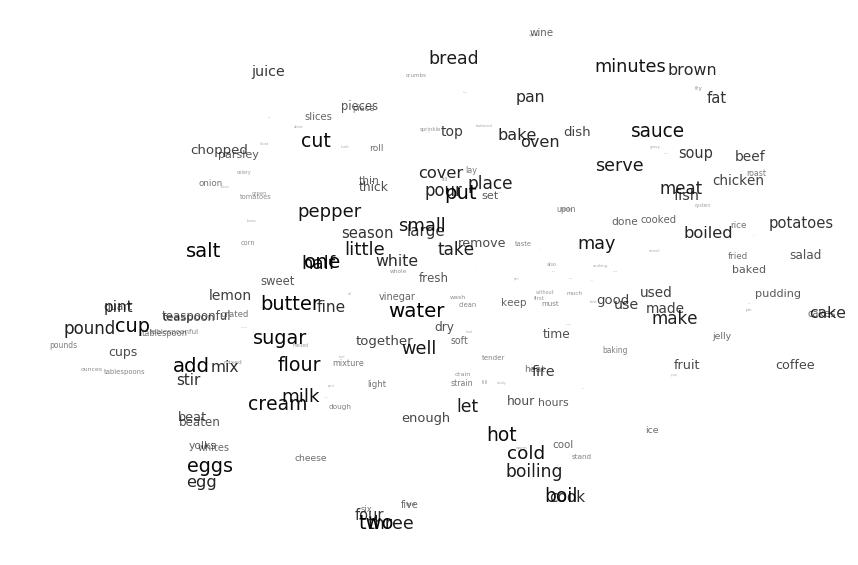

In [29]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

## <span style="color:purple">1.4 Are the parameters correct?
#### <span style="color:purple">Trainning loss

In [30]:
CookBookW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
CookBookW2V_loss.build_vocab(CookBookDF['normalized_sents'].sum())
CookBookW2V_loss.train(CookBookDF['normalized_sents'].sum(), 
                     total_examples=CookBookW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [CookBookW2V_loss.running_training_loss]
losses[0]

705786.75

<span style="color:purple"> **Given the training loss, try to minimize the loss.**

In [31]:
for i in range(19):
    CookBookW2V_loss.train(CookBookDF['normalized_sents'].sum(), 
                     total_examples=CookBookW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(CookBookW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

#### <span style="color:purple"> Correct number of iterations -- by ploting
The loss is monotonicaly decreasing, but the rate decreases as epoch increases. To avoid over fitting, stop training when there is significant change in the rate of decrease. Here, iter=10, instead of the default 5. <br>

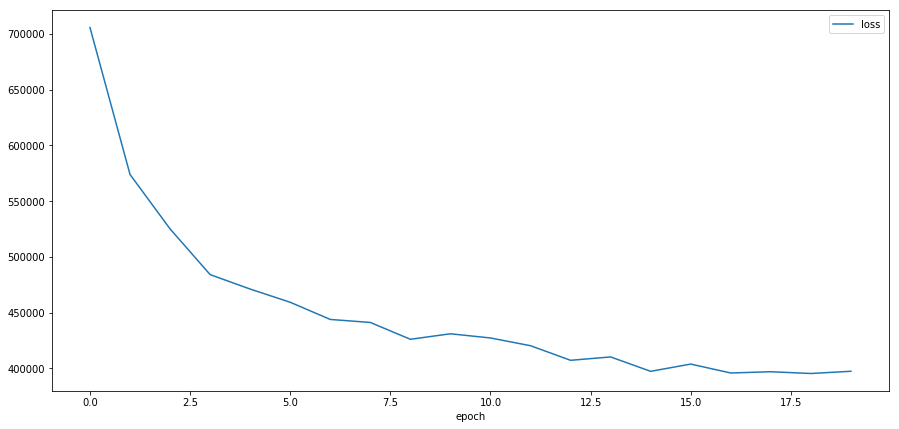

In [32]:
# plot the loss vs epoch
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

#### <span style="color:purple"> Correct number of dimensions to achieve optimal embedding

In [33]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    CookBookW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    CookBookW2V_loss_dims.build_vocab(CookBookDF['normalized_sents'].sum())
    CookBookW2V_loss_dims.train(CookBookDF['normalized_sents'].sum(), 
                     total_examples=CookBookW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    CookBookW2V_loss_dims.train(CookBookDF['normalized_sents'].sum(), 
                     total_examples=CookBookW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(CookBookW2V_loss_dims.running_training_loss/(10+d*10))

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

In [57]:
keywords = ['one','water','salt','add','two','butter','sugar','put','cup','flour','eggs','hot','cold','little','cream','half','milk','pepper','small','cut','boil','sauce','three','boiling','oven','meat','egg']
# CookBookDF['tokenized_text']
# CookBookDF['normalized_tokens'] 

In [35]:
CookBookDF['text_name'] = CookBookDF.index
    
taggedDocs = []
for index, row in CookBookDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_tokens']]
    docKeywords.append(row['text_name']) #This lets us extract individual documnets since text_names's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords))
CookBookDF['Tagged_Text'] = taggedDocs


## <span style="color:purple"> 2.1 Document and Word Relationship 
<span style="color:purple">**Descriptions:**<br>
<span style="color:purple">I have collected different cook books about different countries' dishes, such as American, Swedish, Italian, Juish, and Western; also different cook books for different situations, such as for domestic cooking, hotel custoomers, farm cooking, neighborhood cooking, army cooking; also different cook books for breakfast, luch, tea time, for dishes & beverages, for fish cooking, for sick and convalescent. <br>
    
<span style="color:purple">**Interesting Question:**<br>
<span style="color:purple">How do the cook books from different cultures differ from each other within the sematic space? <br>

<span style="color:purple">**Method:**<br>
<span style="color:purple">(1) **Tokenize and normalize** <br>
CookBookDF['tokenized_text'] contains the tokens. I use nltk stop word list for nomaliztion. CookBookDF['normalized_tokens'] stores the normalized tokens. <br>
(2) Use the **List of Representative Words** find in **Exercise 1.1** <br>
(3) Compare the most similar words of the cook books. <br>
    
<span style="color:purple">**Findings:**<br>
Below are the most similar words for cook books from a certain culture. <br>
American: "acid", "diet", "nature" <br>
Italian: "chicken", "cutlet", "chops", "sweetbreads" <br>
Swedish: "cream", "worcestershire" <br>
Jewish: "carrots", "codfish"<br>
Interstingly, the list above vividly reflect the food preferences of people from different cultures. American people eat little and like natural food. Italian people consume much chicken, sweetbreads. Swedish people consume cream, worcestershire sauce very often. And Jewish like carrots and codfish.<br>
If I hope to dig deeper, I could check the backgrounds and the tradition of each culture, and see how closely the list above describes the culture effect in cooking. 


<span style="color:purple">** Other Findings:** <br>
(1) I search the books relevant to "salads". They are 'The Great Western Cook Book.txt', 'Dishes Beverages of the Old South.txt', "Mrs. Lincoln's Boston Cook Book.txt", 'Food and Cookery for the Sick and Convalescent.txt', 'Breakfast, Luncheon and Tea.txt'. This could be a good way of searching books which satisfy some conditions, just like search the flight which tailors one's traveling preferences. <br>
(2) I try to find a book about bakery. So I earch the book relevant to a list of words that I think are representative to bakery. The words are "water", "flour", "butter", "sugar", "yolk". It retrieves me the book called Domestic Cookery.txt <br>
Excellent!! <br>
(3) I realized that, when I set topn = 15 which is more than the number of retrieved books, some keywords will fill up the rest of the positions.<br>

#### <span style="color:purple"> Train a Doc2Vec model

In [36]:
CookBookD2V = gensim.models.doc2vec.Doc2Vec(CookBookDF['Tagged_Text'], size = 100) #Limiting to 100 dimensions

In [37]:
# find out the text file most similar to 'salads'
CookBookD2V.docvecs.most_similar([ CookBookD2V['salads'] ], topn=5 )


[('The Great Western Cook Book.txt', 0.9660967588424683),
 ('Dishes & Beverages of the Old South.txt', 0.9030768871307373),
 ("Miss Corson's Practical American Cookery.txt", 0.708572506904602),
 ('Breakfast, Luncheon and Tea.txt', 0.6499916315078735),
 ('Svensk-Amerikansk Kokbok.txt', 0.6328397989273071)]

In [38]:
# find out the text file most similar to a list of words
CookBookD2V.docvecs.most_similar([ CookBookD2V['water']+CookBookD2V['flour']+CookBookD2V['butter']+CookBookD2V['sugar']+CookBookD2V['yolk']], topn=15 )


[('flour', 0.9916825890541077),
 ('pepper', 0.9871902465820312),
 ('little', 0.9866809844970703),
 ('cold', 0.9852824211120605),
 ('add', 0.9851853847503662),
 ('small', 0.9849730134010315),
 ('meat', 0.984699547290802),
 ('cut', 0.9846810102462769),
 ('one', 0.9845092296600342),
 ('put', 0.984495997428894),
 ('cup', 0.9844764471054077),
 ('oven', 0.984467625617981),
 ('half', 0.9844624996185303),
 ('hot', 0.9843898415565491),
 ('egg', 0.9843878746032715)]

#### <span style="color:purple"> Find out the words most similar to the cook books

In [39]:
CookBookD2V.most_similar( [ CookBookD2V.docvecs['Miss Corson\'s Practical American Cookery.txt'] ], topn=5) 

[('beverages', 0.9605675339698792),
 ('italian', 0.9586697816848755),
 ('opening', 0.9545525908470154),
 ('diet', 0.9394177198410034),
 ('among', 0.93553626537323)]

In [40]:
CookBookD2V.most_similar( [ CookBookD2V.docvecs['The Italian Cook Book.txt'] ], topn=5) 

[('olive', 0.9989516735076904),
 ('chop', 0.9984978437423706),
 ('cutlets', 0.9975744485855103),
 ('croquettes', 0.9975368976593018),
 ('di', 0.9974881410598755)]

In [41]:
CookBookD2V.most_similar( [ CookBookD2V.docvecs['Svensk-Amerikansk Kokbok.txt'] ], topn=5) 

[('mackerel', 0.9591586589813232),
 ('salted', 0.9577136635780334),
 ('spanish', 0.9489148855209351),
 ('caviar', 0.9420212507247925),
 ('poultry', 0.9379473924636841)]

In [42]:
CookBookD2V.most_similar( [ CookBookD2V.docvecs['The International Jewish Cook Book.txt'] ], topn=5) 

[('soaked', 0.9613216519355774),
 ('toasted', 0.9560102224349976),
 ('lemon', 0.9425853490829468),
 ('turnip', 0.9413629770278931),
 ('tapioca', 0.9339885711669922)]

In [43]:
CookBookD2V.most_similar( [ CookBookD2V.docvecs['Food and Cookery for the Sick and Convalescent.txt'] ], topn=5) 

[('starch', 0.9431891441345215),
 ('nutritive', 0.937711238861084),
 ('combustion', 0.9344935417175293),
 ('disagreeable', 0.9125670790672302),
 ('diet', 0.9038425087928772)]

In [44]:
CookBookD2V.most_similar( [ CookBookD2V.docvecs['Manual for Army Cooks.txt'] ], topn=5) 

[('cut', 0.9911088347434998),
 ('beans', 0.9896878004074097),
 ('paprika', 0.9894720315933228),
 ('grated', 0.98839271068573),
 ('fish', 0.9854676723480225)]

#### <span style="color:purple"> Plot Heatmap words and documents

In [58]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = CookBookD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, CookBookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

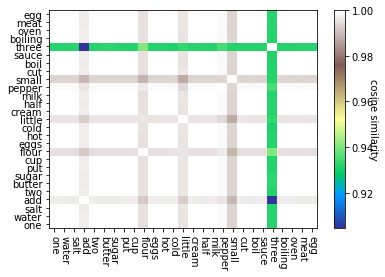

In [59]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

## <span style="color:purple">2.2 Plot Heatmap documents and documents
<span style="color:purple">**Discussions:**<br>
<span style="color:purple"> Let's just focus on the cook books with distinct culture background. "Svensk-Amerikansk Kokbok.txt" for Swedish, "The Great Western Cook Book.txt" for western, "The International Jewish Cook Book.txt" for Jewish, "Jennie June's American Cookery Book.txt" for American.<br>
The heatmap shows that Jewish cook book is neither similar nor dissimilar to the Western's, quite similar to the Swedish, and very dissimilar to the American's.
The Western cook book is similar to the Swedish, which is reasonable as Sweden is an European country. The Western is totally dissimilar to the American's, which is similar due to the distinct cultures and history. <br>
    
<span style="color:purple"> **Further interesting research question:**<br>
<span style="color:purple"> To incorporate more analysis in the culture aspect, I should read more history of diffent cultures. A potential interesting question is how the culture affects the cookings, and how the dissimilarities of cookings across culture evolve over time. To do so, I need to collect cook books from different cultures over time. <br>

In [60]:
targetDocs = CookBookDF['text_name'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = CookBookD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, CookBookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

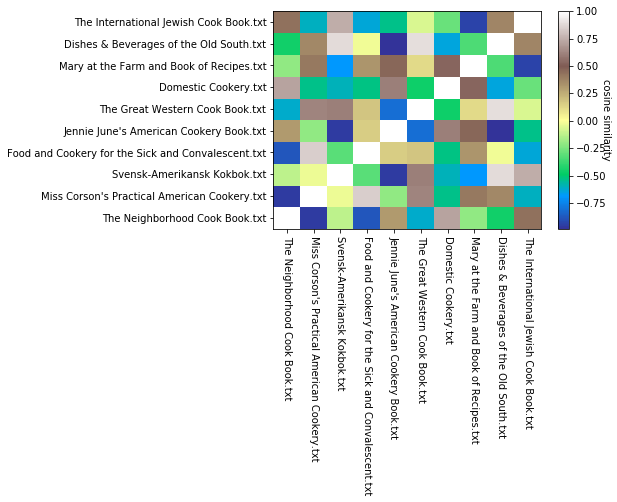

In [61]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

#### <span style="color:purple"> Plot Heatmap words and documents

In [62]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = CookBookD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, CookBookD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

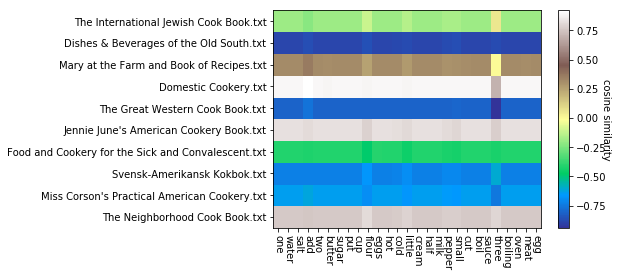

In [63]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

## <span style="color:purple">3.1 Projection
<span style="color:purple">**Interesting Question:**<br>
<span style="color:purple">How the words will be projected given the dimensions, in a cooking context? What are the extra information could be derived from the projection?<br>

<span style="color:purple">**Method:**<br>
<span style="color:purple"> (1) Three dimensions are: temperature (hot vs cold), status (liquid vs solid), food (meat vs vegetables)<br>
(2) Three list of words, numbers (one, two etc.), actions (pour, mix, etc.), cookers (oven, pan etc.)<br>
(3) projection<br>
    
<span style="color:purple">**Findings:**<br>
The most interesting one is the third plot for cookers.<br>
Under dimension *temperature*, oven is at one extreme, corresponding to "hot, boiling"; while tablespoon and teaspoon at the other extreme, corresponding to "cold, soaked". <br>
This distribution keeps the same for the dimensions *status* and *food*.
Under dimension *food*, oven and pan are in one extreme, telling that people use them to cook meat, fish, beef. Teaspoon is at the other extreme, telling that people may use it for eating vegetables, or salad (a bit wierd). Notice that the distances between teaspoon and tablespoon are different under the three dimensions. I may need to learn more about the functions of both of them to give a better explanation.

In [109]:
CookBook_model = gensim.models.word2vec.Word2Vec.load('CookBookW2V')
#words to create dimensions
CBTargetWords = ['hot','boiling','warm','cold','thin','thick','salt','sugar']
                 
#words we will be mapping
CBTargetWords += ["butter","salads","fire","soaked","cover","vegetable", "yolk","bread","cream","bake", "oven","pan","pound", "pint", "onion", "fruit", "pudding", "fried", "rice", "army","lemon","sick", "housekeeping", "hotel", "italian", "domestic", "breakfast", "lunch", "tea", "coffee"]


In [110]:
wordsSubMatrix = []
for word in CBTargetWords:
    wordsSubMatrix.append(CookBook_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.03181042, -0.31913367,  0.21022673, ...,  0.35006127,
        -0.4741677 , -0.01388136],
       [-0.0698988 , -0.232963  ,  0.16161878, ...,  0.24614763,
        -0.3819538 , -0.05037878],
       [-0.08198459, -0.35888916,  0.20975623, ...,  0.33781612,
        -0.5279024 , -0.09068716],
       ...,
       [-0.0056142 , -0.03182752,  0.01831606, ...,  0.03487657,
        -0.05052434, -0.00334229],
       [-0.0138569 , -0.11988679,  0.05939059, ...,  0.11777288,
        -0.17169605, -0.02562294],
       [ 0.08674499,  0.09680294, -0.08305287, ..., -0.05710452,
         0.18801646,  0.07140481]], dtype=float32)

In [111]:
pcaWordsCookBook = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataCookBook = pcaWordsCookBook.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsCookBook = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataCookBook)


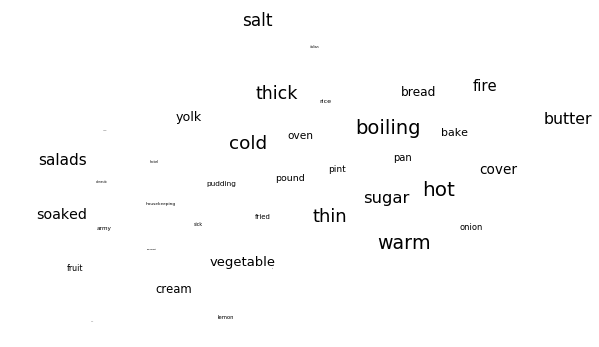

In [112]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsCookBook[:, 0], tsneWordsCookBook[:, 1], alpha = 0) 
for i, word in enumerate(CBTargetWords):
    ax.annotate(word, (tsneWordsCookBook[:, 0][i],tsneWordsCookBook[:, 1][i]), size =  20 * (len(CBTargetWords) - i) / len(CBTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [113]:
# to get the dimensions:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [130]:
# define dimensions
temperature = dimension(CookBook_model, ['hot','warm','boiling'], ['cold', 'soaked'])
status = dimension(CookBook_model, ['salt','sugar','flour'], ['water','liquor','milk'])
food = dimension(CookBook_model, ['vegetable','salads'], ['meat','beef','chicken','fish'])

In [131]:
# get some words
numbers = ["one","two","half","four","six","three"]

actions = ["add", "put","cut","boil", "pour","mix","stir"]

units = ["oven", "cup","pan","teaspoon","tablespoon"]

In [137]:
# to project words in a word list to the three dimensions
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(CookBook_model[word].reshape(1,-1), temperature.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(CookBook_model[word].reshape(1,-1), status.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(CookBook_model[word].reshape(1,-1), food.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'temperature': g, 'status': r, 'food': c}, index = word_list)
    return df

In [138]:
# get projections
Numbersdf = makeDF(CookBook_model, numbers) 
Actionsdf = makeDF(CookBook_model, actions)
Unitsdf = makeDF(CookBook_model, units)

In [140]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

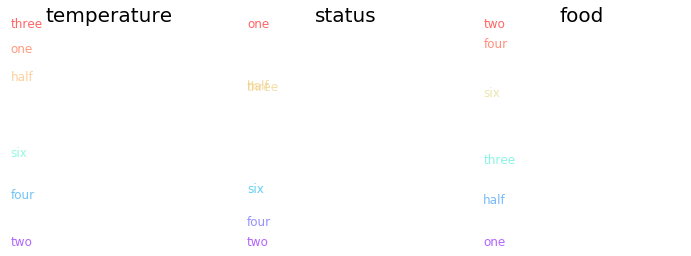

In [141]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Numbersdf, 'temperature')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Numbersdf, 'status')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Numbersdf, 'food')
plt.show()

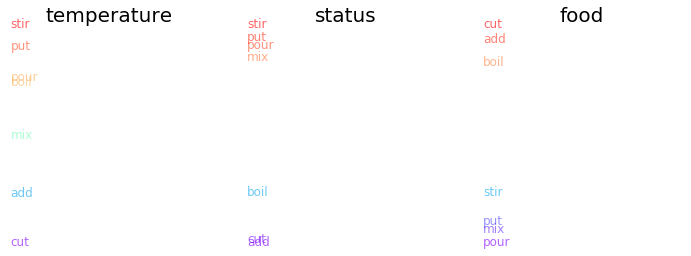

In [142]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Actionsdf, 'temperature')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Actionsdf, 'status')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Actionsdf, 'food')
plt.show()

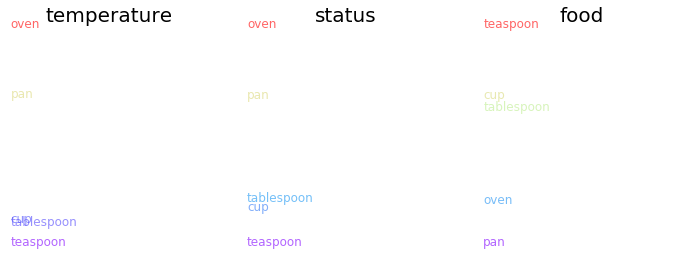

In [143]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Unitsdf, 'temperature')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Unitsdf, 'status')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Unitsdf, 'food')
plt.show()

In [ ]:
estimatesB_4=[]
for x in range(20):
    CookBookW2VB = gensim.models.word2vec.Word2Vec(CookBookDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB_2.append(cos_difference(CookBookW2VB, 'meat', 'vegetable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
print("The 90% confidence interval for the cosine distance between \"meat\" and \"vegetable\" is:\n",estimatesB_2[1], estimatesB_2[-2])
